# Grad-CAM class activation visualization

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Source:** https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/grad_cam.ipynb<br>
**Date created:** 2020/04/26<br>
**Last modified:** 2021/03/07<br>
**Description:** How to obtain a class activation heatmap for an image classification model.

Adapted from Deep Learning with Python (2017).
## Setup

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` use `model.summary()`
to see the names of all layers in the model.

In [11]:
model_builder = tf.keras.models.load_model('saved_models\\scotts-cifar10-cnn')
model_builder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

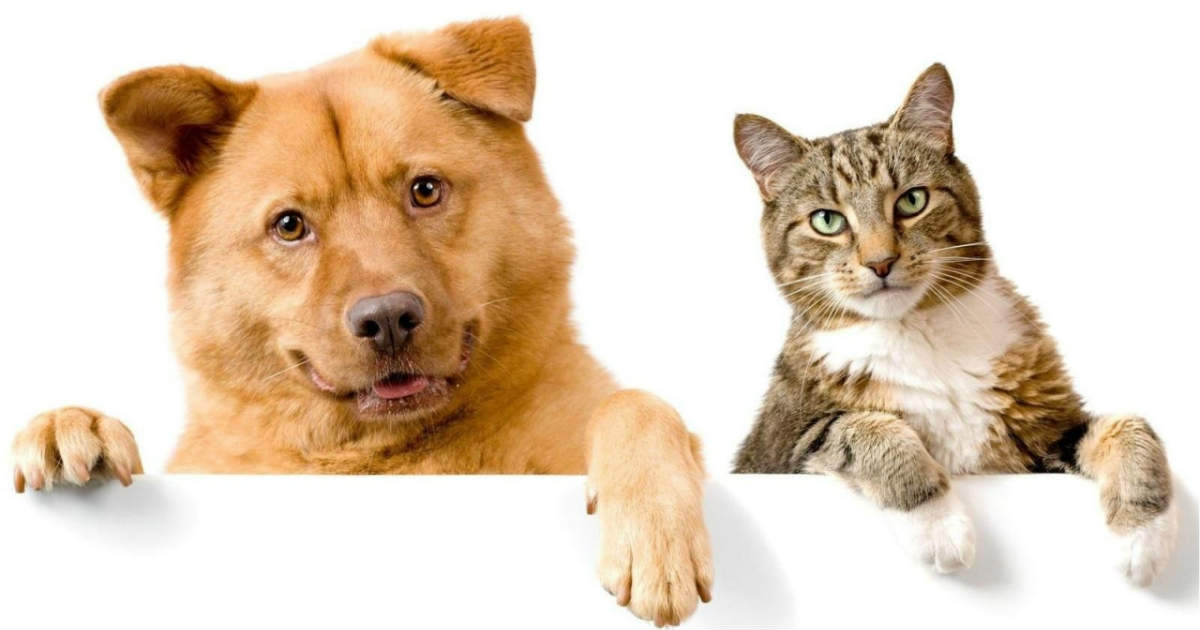

In [12]:
#model_builder = keras.applications.xception.Xception
model_builder = tf.keras.models.load_model('saved_models\\scotts-cifar10-cnn')
# img_size = (299, 299)
img_size = (32, 32)
model_builder.summary()
#preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_2"

# The local path to our target image
#img_path = keras.utils.get_file(
#    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
#)

img_path = "dog-and-cat-cover.jpg"

display(Image(img_path))


## The Grad-CAM algorithm

In [13]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


## Let's test-drive it

horse


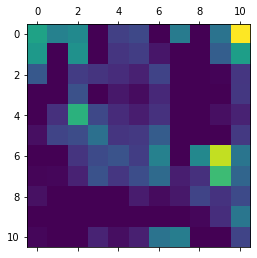

In [14]:
# Prepare image
img_array = get_img_array(img_path, size=img_size)

# Make model
model = model_builder

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

idx = preds.argmax()
print(class_names[idx])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name,
                              pred_index =idx)

# Display heatmap
plt.matshow(heatmap)
plt.show()


## Create a superimposed visualization

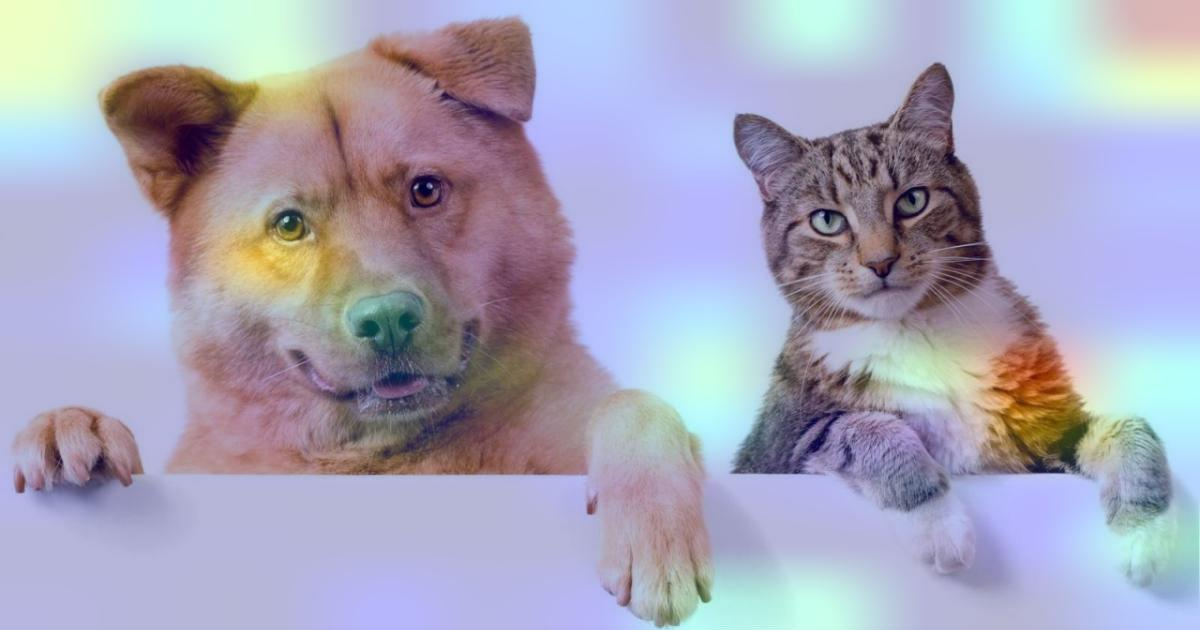

In [15]:

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

## Let's try another image

We will see how the grad cam explains the model's outputs for a multi-label image. Let's
try an image with a cat and a dog together, and see how the grad cam behaves.

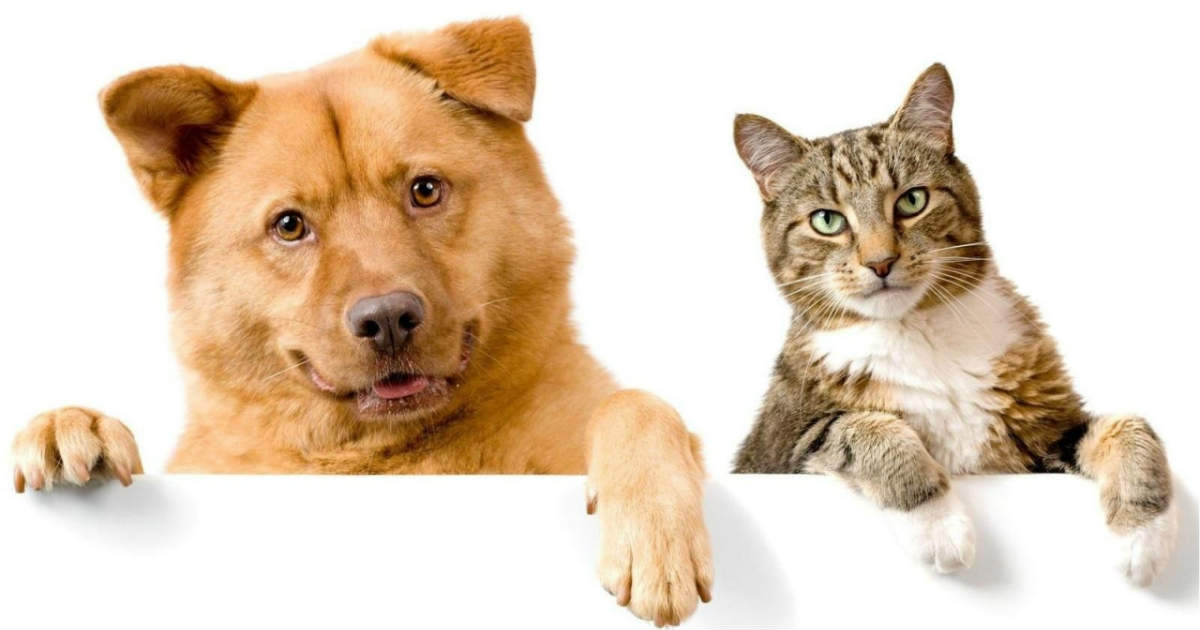

In [16]:
model_builder = tf.keras.models.load_model('scotts-cifar10-cnn')
img_size = (32,32)

last_conv_layer_name = "conv2d_2"

#The local path to our target image
img_path = 'dog-and-cat-cover.jpg'

display(Image(img_path))

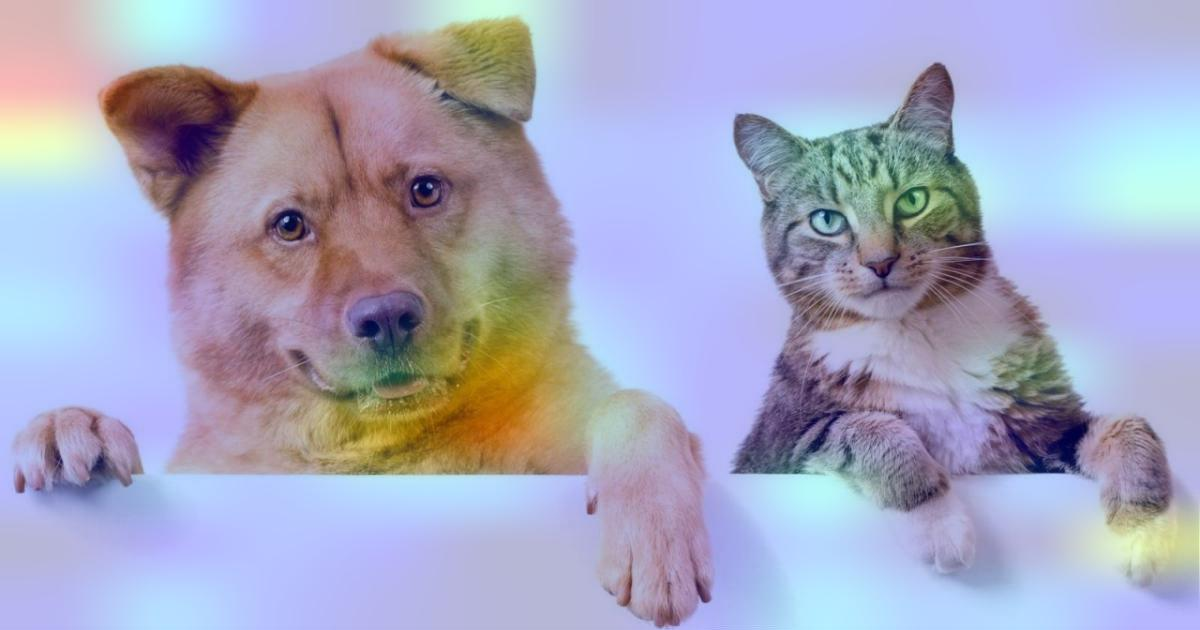

In [17]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=3)

save_and_display_gradcam(img_path, heatmap)

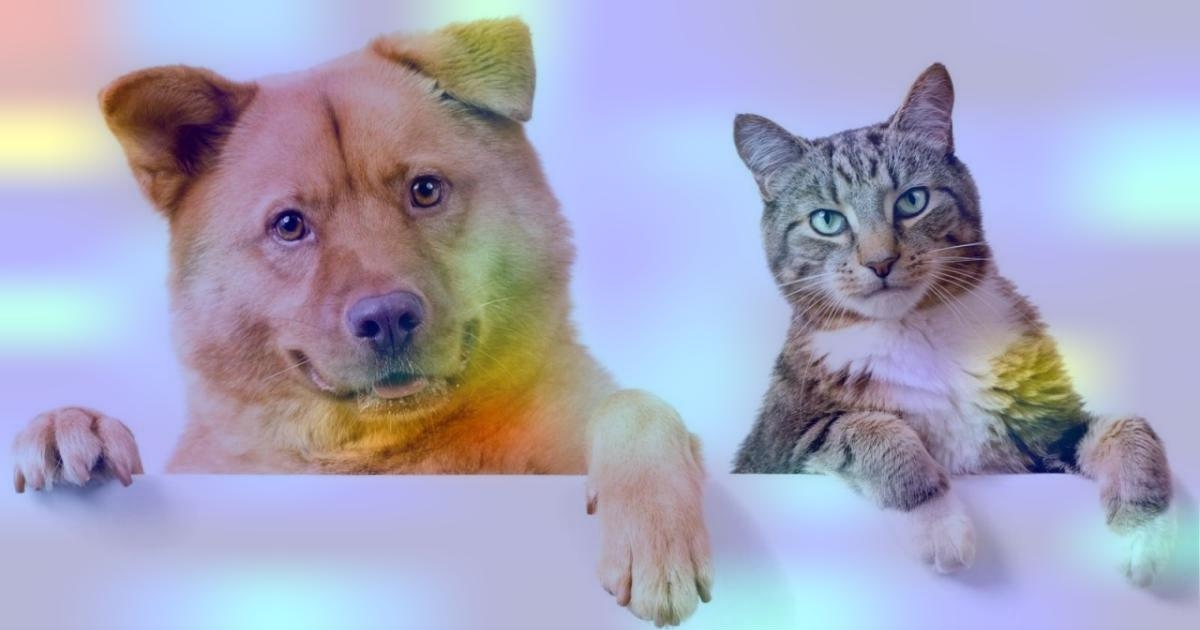

In [18]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=5)

save_and_display_gradcam(img_path, heatmap)